<a href="https://colab.research.google.com/github/SandraPuig/tfg-BA/blob/main/B2_An_dato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2. ANÁLISIS DEL DATO - SEGMENTACIÓN:**

### **B1 - PASOS INICIALES**

In [ ]:
#--------- CARGAR LIBRERÍAS ---------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from IPython.display import display, Markdown
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [ ]:
# ----------- PRESENTACIÓN -------------

# Cargar el dataset completo
df = pd.read_excel('/content/BBDD_E1_listo.xlsx')

# Columnas a excluir para clustering (identificadores no numéricos)
columnas_no_usar = ['municipio_cm', 'distrito_cm']

# Extraer columnas numéricas excluyendo identificadores
columnas_numericas = [col for col in df.columns if col not in columnas_no_usar and pd.api.types.is_numeric_dtype(df[col])]

# Variables estratégicas definidas para segmentación
variables_estrategicas = [
    'renta_media', 'pib_percapita', 'tasa_paro',
    'preciom2_compra', 'preciom2_alquiler', 'rentabilidad_bruta_calc',
    'viabilidad_financiera', 'indice_esfuerzo_compra', 'indice_presion_inmobiliaria',
    'transacciones_m2', 'tasa_transacciones_pob',
    'edad_media', 'grado_extranj', 'grado_envejecimiento', 'grado_juventud',
    'ratio_transporte', 'ratio_centros_salud', 'ratio_farmacias',
    'ratio_bibliotecas', 'ratio_centros_educativos',
    'densidad_poblacional', 'movilidad'
]

# Filtrar variables que están en ambas listas (numéricas y estratégicas)
variables_finales = [var for var in variables_estrategicas if var in columnas_numericas]

# Subset para clustering
X = df[variables_finales].copy()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Guardar identificadores para interpretación
municipios = df['municipio_cm'].copy()
distritos = df['distrito_cm'].copy()

# Mostrar resumen
print(f"Variables usadas para clustering: {variables_finales}")
print(f"Shape de X escalado: {X_scaled.shape}")



Variables usadas para clustering: ['renta_media', 'pib_percapita', 'tasa_paro', 'preciom2_compra', 'preciom2_alquiler', 'rentabilidad_bruta_calc', 'viabilidad_financiera', 'indice_esfuerzo_compra', 'indice_presion_inmobiliaria', 'transacciones_m2', 'tasa_transacciones_pob', 'edad_media', 'grado_extranj', 'grado_envejecimiento', 'grado_juventud', 'ratio_transporte', 'ratio_centros_salud', 'ratio_farmacias', 'ratio_bibliotecas', 'ratio_centros_educativos', 'densidad_poblacional', 'movilidad']
Shape de X escalado: (200, 22)


### **B2. MÉTODO K-MEANS CLUSTERING**

### Análisis comparativo para distintos valores de k

k=2: Inercia (WCSS) = 3097.54, Silhouette = 0.342
k=3: Inercia (WCSS) = 2423.79, Silhouette = 0.270
k=4: Inercia (WCSS) = 1948.46, Silhouette = 0.300
k=5: Inercia (WCSS) = 1738.61, Silhouette = 0.277
k=6: Inercia (WCSS) = 1563.83, Silhouette = 0.284
k=7: Inercia (WCSS) = 1471.55, Silhouette = 0.228
k=8: Inercia (WCSS) = 1391.26, Silhouette = 0.237
k=9: Inercia (WCSS) = 1330.18, Silhouette = 0.238


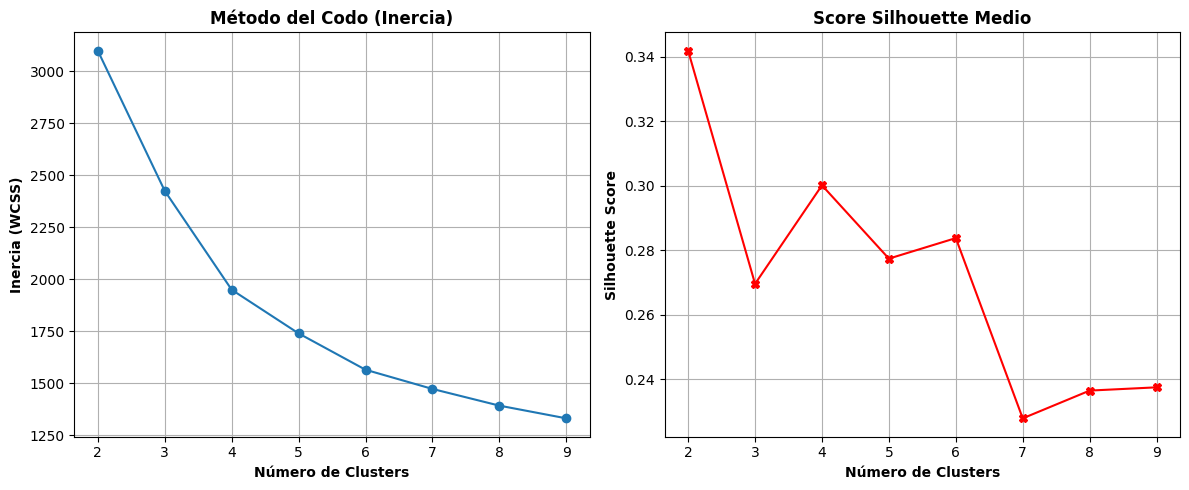

In [ ]:
#--------- ANÁLISIS PREVIO ---------
# Rango de valores de k a evaluar (número de segmentos estratégicos)
rango_k = range(2, 10)  # valores de k a evaluar
inercia = []            # WCSS: cohesión intra-cluster
silhouette_scores = [] # Silhouette: separación entre clusters

for k in rango_k:
    modelo = KMeans(n_clusters=k, n_init=10, random_state=42)
    etiquetas = modelo.fit_predict(X_scaled)
    inercia.append(modelo.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, etiquetas))

# Mostrar resultados comparativos
display(Markdown("### Análisis comparativo para distintos valores de k"))
for k, w, s in zip(rango_k, inercia, silhouette_scores):
    print(f"k={k}: Inercia (WCSS) = {w:.2f}, Silhouette = {s:.3f}")


#--------- GRÁFICO K-MEANS ---------
plt.figure(figsize=(12, 5))

# Gráfico del método del codo
plt.subplot(1, 2, 1)
plt.plot(rango_k, inercia, marker='o')
plt.title("Método del Codo (Inercia)", fontweight="bold")
plt.xlabel("Número de Clusters", fontweight="bold")
plt.ylabel("Inercia (WCSS)", fontweight="bold")
plt.grid(True)

# Gráfico del coeficiente silhouette
plt.subplot(1, 2, 2)
plt.plot(rango_k, silhouette_scores, marker='X', color='red')
plt.title("Score Silhouette Medio", fontweight="bold")
plt.xlabel("Número de Clusters", fontweight="bold")
plt.ylabel("Silhouette Score", fontweight="bold")
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# Escoge el K óptimo basado en análisis anterior (ejemplo: K=4)
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
labels_kmeans = kmeans_final.fit_predict(X_scaled)

# Añadir etiquetas al DataFrame original
df['cluster_kmeans'] = labels_kmeans

# -------------------------------
# MÉTRICAS DE EVALUACIÓN
# -------------------------------
sil_final = silhouette_score(X_scaled, labels_kmeans)
ch_final = calinski_harabasz_score(X_scaled, labels_kmeans)
db_final = davies_bouldin_score(X_scaled, labels_kmeans)

# -------------------------------
# IMPRESIÓN DE RESULTADOS
# -------------------------------
print(f"\n\033[1mModelo final K-Means con k = {k_optimo}\033[0m")
print(f"\033[1mSilhouette Score:\033[0m {sil_final:.3f} (mayor = mejor separación)")
print(f"\033[1mCalinski-Harabasz Index:\033[0m {ch_final:.2f} (mayor = mejor estructura)")
print(f"\033[1mDavies-Bouldin Index:\033[0m {db_final:.3f} (menor = mejor compacidad)")



Modelo final K-Means con k = 3
Silhouette Score: 0.259 (mayor = mejor separación)
Calinski-Harabasz Index: 79.62 (mayor = mejor estructura)
Davies-Bouldin Index: 1.378 (menor = mejor compacidad)


<ipython-input-137-2094416781>:17: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(


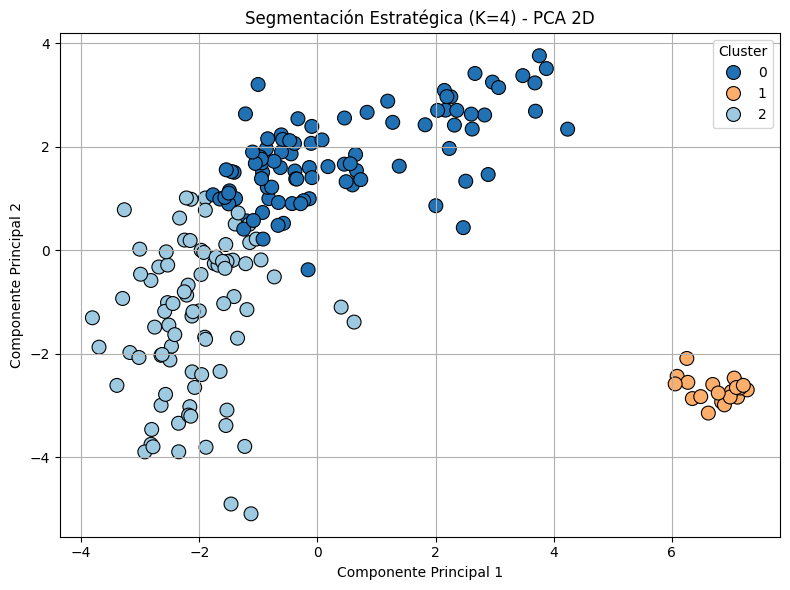

In [ ]:
# -------------------------------
#VISUALIZACIÓN
# -------------------------------
# Reducción de dimensiones para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrame para graficar
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels_kmeans

# Colores suaves y diferenciados
colores_personalizados =  ['#2171B5', '#FDAE6B', '#9ECAE1', '#E34A33']  # Azul claro, naranja suave, azul medio, naranja claro

# Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette=colores_personalizados,
    s=100,
    edgecolor='black'
)
plt.title('Segmentación Estratégica (K=4) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()



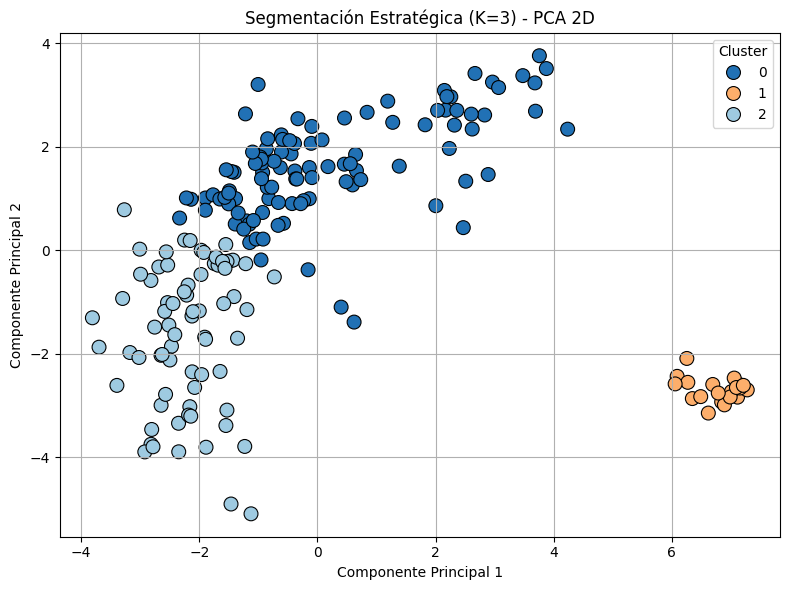

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Entrenar K-Means con k=3
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Reducción de dimensiones para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrame para graficar
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels_kmeans

# Colores suaves y diferenciados para 3 clusters
colores_personalizados = ['#2171B5', '#FDAE6B', '#9ECAE1']  # Azul, naranja suave, azul medio

# Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette=colores_personalizados,
    s=100,
    edgecolor='black'
)
plt.title('Segmentación Estratégica (K=3) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Silhouette Score general
sil_score = silhouette_score(X_scaled, labels_kmeans)
ch_score = calinski_harabasz_score(X_scaled, labels_kmeans)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")


Silhouette Score: 0.270
Calinski-Harabasz Index: 80.311


In [ ]:
# Obtener media de las variables por clúster
descripcion_clusters = df.groupby('cluster_kmeans')[variables_estrategicas].mean()
print("Resumen de características promedio por clúster:")
display(descripcion_clusters)


Resumen de características promedio por clúster:


,renta_media,pib_percapita,tasa_paro,preciom2_compra,preciom2_alquiler,rentabilidad_bruta_calc,viabilidad_financiera,indice_esfuerzo_compra,indice_presion_inmobiliaria,transacciones_m2,...,grado_extranj,grado_envejecimiento,grado_juventud,ratio_transporte,ratio_centros_salud,ratio_farmacias,ratio_bibliotecas,ratio_centros_educativos,densidad_poblacional,movilidad
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.390139,0.772629,-0.285080,0.342152,0.321290,-0.102129,0.255200,0.497841,-0.23670,0.717171,...,0.075148,0.063097,0.218497,-0.155366,0.822015,-0.064626,0.638900,0.138156,0.711725,0.626683
1,2.124666,2.391577,0.266037,1.591821,1.793733,-0.158116,-2.172192,-1.921454,1.95882,2.332438,...,2.151752,2.262601,2.028614,0.057511,0.860913,0.025822,-0.011392,-0.657272,2.211434,1.511502
2,-0.312800,-0.071696,0.498751,-0.551774,-0.301332,0.494826,-0.500800,-0.306187,0.31432,-0.147909,...,-0.082230,0.323172,-0.614439,1.161891,0.203488,0.795344,0.145552,0.466625,-0.164621,-0.087728


### **B3. DBSCAN MODEL**

In [ ]:
# Técnica para segmentaciones no lineales, con detección automática de outliers y sin necesidad de fijar el número de clusters a priori.

In [ ]:
#--------- PRUEBAS CON PARÁMETROS ---------

# Probar diferentes combinaciones de eps y min_samples
eps_values = [0.5, 0.7, 1.0, 1.3, 1.6]
min_samples_values = [3, 5, 7]

resultados_dbscan = []

for eps in eps_values:
    for min_samples in min_samples_values:
        modelo = DBSCAN(eps=eps, min_samples=min_samples)
        etiquetas = modelo.fit_predict(X_scaled)

        n_clusters = len(set(etiquetas)) - (1 if -1 in etiquetas else 0)
        n_ruido = list(etiquetas).count(-1)

        if n_clusters > 1:
            silhouette = silhouette_score(X_scaled, etiquetas)
        else:
            silhouette = None

        resultados_dbscan.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'outliers': n_ruido,
            'silhouette': silhouette
        })

# Mostrar resultados como tabla
resultados_df = pd.DataFrame(resultados_dbscan)
display(resultados_df.sort_values(by='silhouette', ascending=False))


,eps,min_samples,n_clusters,outliers,silhouette
13,1.6,5,2,171,0.220231
14,1.6,7,2,173,0.219921
9,1.3,3,2,177,0.192638
10,1.3,5,2,179,0.173361
6,1.0,3,3,181,0.134595
12,1.6,3,6,153,-0.132864
0,0.5,3,1,196,NaN
1,0.5,5,0,200,NaN
2,0.5,7,0,200,NaN
3,0.7,3,1,194,NaN


In [ ]:
#--------- MODELO FINAL DBSCAN CON MEJORES PARÁMETROS ---------
# Elegimos manualmente los mejores valores (ajústalos según lo que veas)
eps_final = 1.0
min_samples_final = 5

modelo_final = DBSCAN(eps=eps_final, min_samples=min_samples_final)
etiquetas_finales = modelo_final.fit_predict(X_scaled)

df['cluster_dbscan'] = etiquetas_finales

# Silhouette si es válido
if len(set(etiquetas_finales)) - (1 if -1 in etiquetas_finales else 0) > 1:
    sil_dbscan = silhouette_score(X_scaled, etiquetas_finales)
    print(f"✅ Silhouette final DBSCAN: {sil_dbscan:.3f}")
else:
    print("⚠️ No se puede calcular Silhouette: solo hay 1 cluster o todos son ruido.")

⚠️ No se puede calcular Silhouette: solo hay 1 cluster o todos son ruido.


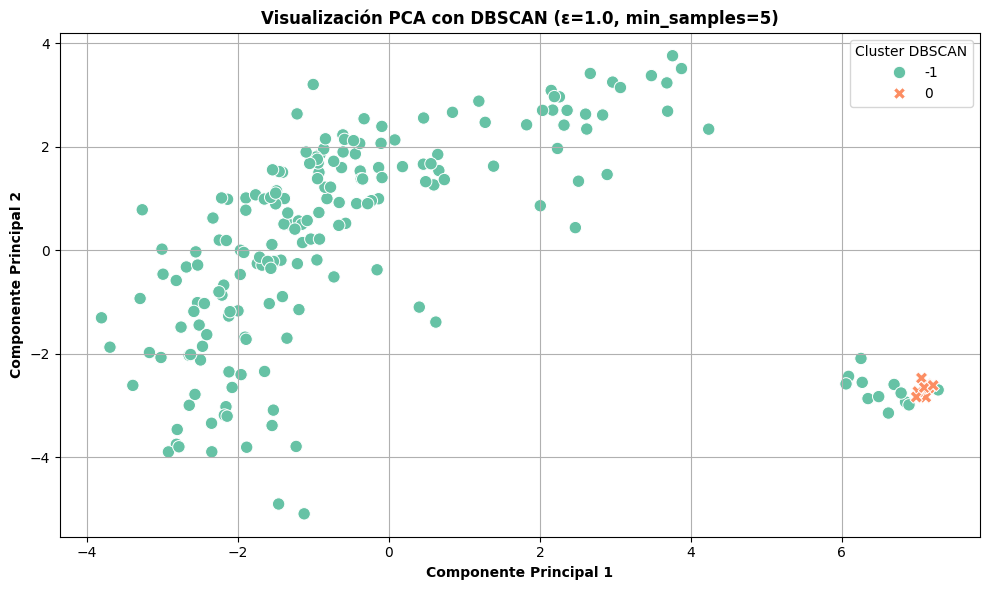

In [ ]:
#--------- VISUALIZACIÓN PCA ---------

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", n_colors=len(set(etiquetas_finales)))

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=etiquetas_finales,
    palette=palette,
    style=etiquetas_finales,
    s=80
)

plt.title(f"Visualización PCA con DBSCAN (ε={eps_final}, min_samples={min_samples_final})", fontweight='bold')
plt.xlabel("Componente Principal 1", fontweight='bold')
plt.ylabel("Componente Principal 2", fontweight='bold')
plt.legend(title="Cluster DBSCAN", loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

### **B4. GAUSSIAN MIXTURE MODEL (GMM)**

k=2: BIC = 4605.39, Silhouette = 0.331
k=3: BIC = 2749.05, Silhouette = 0.253
k=4: BIC = 1227.38, Silhouette = 0.264
k=5: BIC = 2349.67, Silhouette = 0.249
k=6: BIC = 2659.28, Silhouette = 0.261
k=7: BIC = 2835.35, Silhouette = 0.221
k=8: BIC = 3394.01, Silhouette = 0.246
k=9: BIC = 2556.09, Silhouette = 0.240


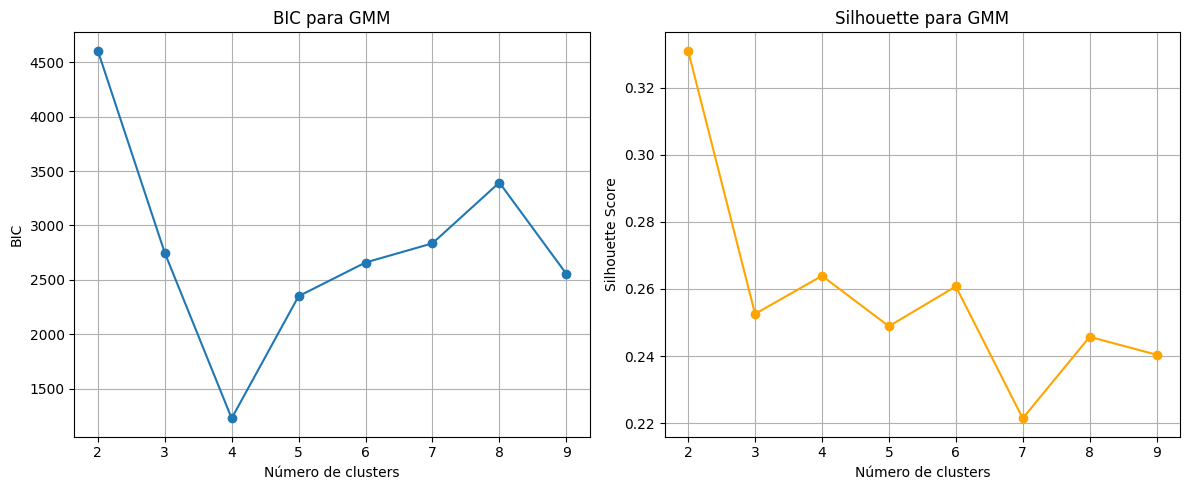

In [ ]:
# --------- Análisis comparativo ---------
rango_k = range(2, 10)
bic_scores = []
silhouette_scores = []

for k in rango_k:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))  # BIC penaliza complejidad modelo
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Mostrar resultados
for k, bic, sil in zip(rango_k, bic_scores, silhouette_scores):
    print(f"k={k}: BIC = {bic:.2f}, Silhouette = {sil:.3f}")


# ---------Visualización de métricas BIC y Silhouette ---------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rango_k, bic_scores, marker='o')
plt.title("BIC para GMM")
plt.xlabel("Número de clusters")
plt.ylabel("BIC")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rango_k, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette para GMM")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()



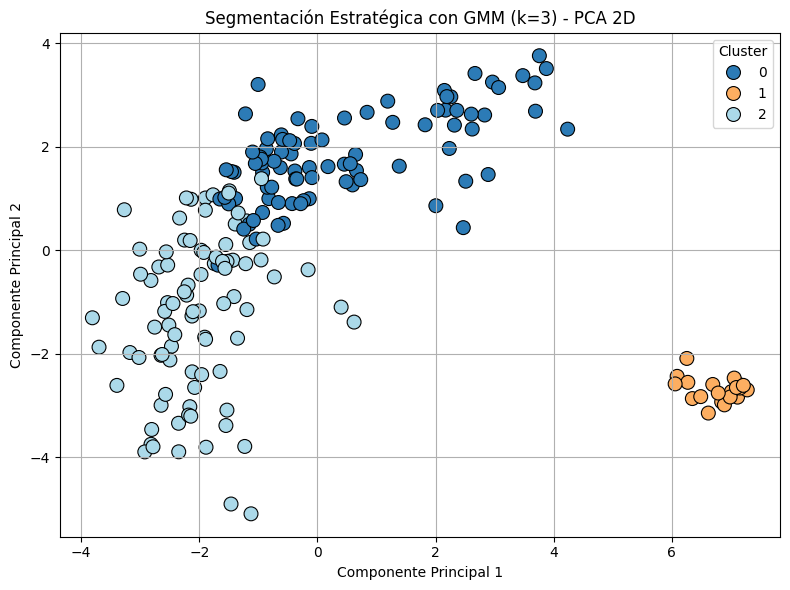

In [ ]:
# --------- Entrenar modelo GMM con k óptimo ---------
k_optimo = 3  # Cambiar según resultados
gmm_final = GaussianMixture(n_components=k_optimo, covariance_type='full', random_state=42)
gmm_final.fit(X_scaled)
labels_gmm = gmm_final.predict(X_scaled)



# --------- Visualización clusters con PCA ---------

# Reducción dimensional PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DataFrame para graficar
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels_gmm

# Paleta personalizada para 3 clusters
colores_personalizados = ['#2C7BB6', '#FDAE61', '#ABD9E9']  # azul fuerte, naranja suave, azul claro

# Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette=colores_personalizados,
    s=100,
    edgecolor='black'
)
plt.title(f'Segmentación Estratégica con GMM (k={k_optimo}) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

**Evaluación del modelo GMM (3 clusters):**

Silhouette Score: 0.253
Calinski-Harabasz Index: 78.35
Davies-Bouldin Index: 1.397


**Tamaños de los clusters:**

{np.int64(0): np.int64(89), np.int64(1): np.int64(21), np.int64(2): np.int64(90)}


**Promedio de variables estratégicas por cluster:**

cluster,Cluster 0,Cluster 1,Cluster 2
renta_media,0.41,2.12,-0.30
pib_percapita,0.80,2.39,-0.06
tasa_paro,-0.30,0.27,0.48
preciom2_compra,0.37,1.59,-0.54
preciom2_alquiler,0.34,1.79,-0.30
rentabilidad_bruta_calc,-0.12,-0.16,0.49
viabilidad_financiera,0.27,-2.17,-0.48
indice_esfuerzo_compra,0.52,-1.92,-0.29
indice_presion_inmobiliaria,-0.25,1.96,0.30
transacciones_m2,0.76,2.33,-0.15


**Ejemplos de municipios por cluster:**

**Cluster 0:** Ajalvir, Alamo, Alcalá de Henares, Alcobendas, Alcorcón

**Cluster 1:** Arganzuela, Barajas, Carabanchel, Centro, Chamartín

**Cluster 2:** Acebeda, Alameda del Valle, Aldea del Fresno, Ambite, Anchuelo

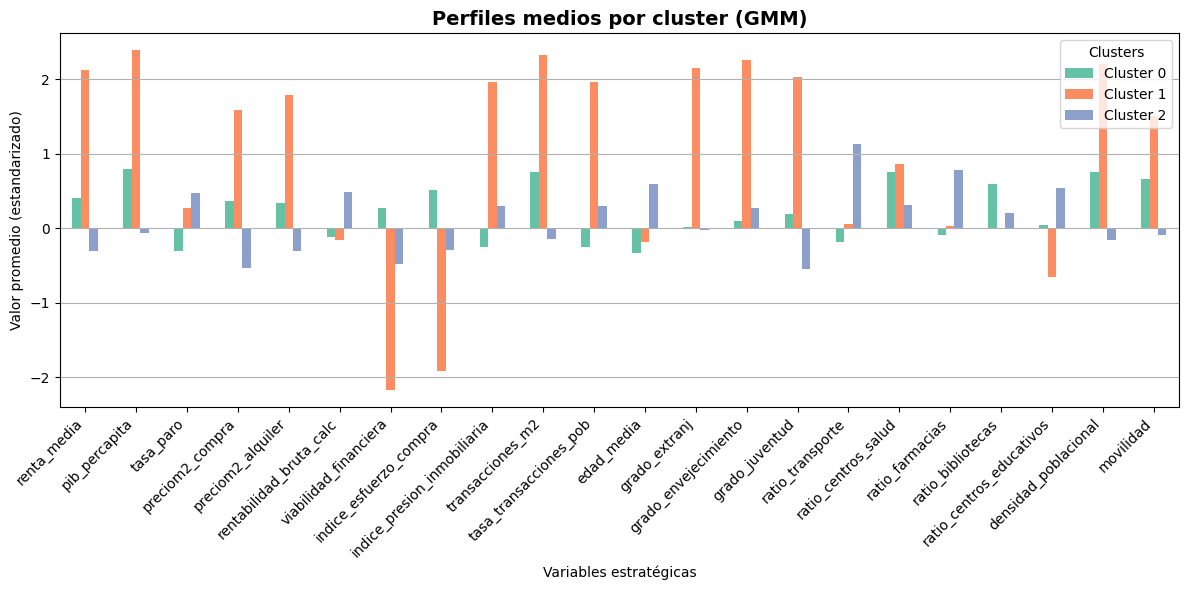

In [ ]:
# Entrenamos el modelo GMM con 3 componentes
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
labels_gmm = gmm.predict(X_scaled)

# Evaluamos calidad del clustering
sil = silhouette_score(X_scaled, labels_gmm)
ch = calinski_harabasz_score(X_scaled, labels_gmm)
db = davies_bouldin_score(X_scaled, labels_gmm)

display(Markdown("**Evaluación del modelo GMM (3 clusters):**"))
print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski-Harabasz Index: {ch:.2f}")
print(f"Davies-Bouldin Index: {db:.3f}")

# Tamaño de cada cluster
unique, counts = np.unique(labels_gmm, return_counts=True)
display(Markdown("**Tamaños de los clusters:**"))
print(dict(zip(unique, counts)))


# -------- Perfil de cada cluster --------
# Creamos un DataFrame con los promedios de cada cluster
resumen_clusters = []
for i in range(3):
    cluster_i = df[labels_gmm == i]
    media = cluster_i[variables_estrategicas].mean().round(2).to_dict()
    media['cluster'] = f'Cluster {i}'
    resumen_clusters.append(media)

resumen_df = pd.DataFrame(resumen_clusters).set_index('cluster')

display(Markdown("**Promedio de variables estratégicas por cluster:**"))
display(resumen_df.T)  # transpuesta: variables en filas, clusters en columnas

# Asociamos cada municipio con su cluster GMM
df['cluster_gmm'] = labels_gmm  # Asegúrate de tener esta columna asignada
display(Markdown("**Ejemplos de municipios por cluster:**"))
for i in range(3):
    municipios_cluster = df[df['cluster_gmm'] == i]['municipio_cm'].head(5).tolist()
    display(Markdown(f"**Cluster {i}:** {', '.join(municipios_cluster)}"))

# Gráfico comparativo
# Elegimos una paleta de colores más profesional
colors = sns.color_palette("Set2", n_colors=3)

# Gráfico mejorado
resumen_df.T.plot(kind='bar', figsize=(12, 6), color=colors)

plt.title("Perfiles medios por cluster (GMM)", fontsize=14, weight='bold')
plt.ylabel("Valor promedio (estandarizado)")
plt.xlabel("Variables estratégicas")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.legend(title="Clusters", loc='upper right')
plt.show()

In [ ]:
# --------- Métricas de Evaluación K-means vs GMM ---------

# Valores de k para comparar
k_optimo = 3  # Cambia según lo que hayas decidido

# Entrenar K-Means
kmeans = KMeans(n_clusters=k_optimo, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Entrenar GMM
gmm = GaussianMixture(n_components=k_optimo, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
labels_gmm = gmm.predict(X_scaled)

# Función para calcular métricas
def calcular_metricas(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db

# Calcular métricas para K-Means
sil_k, ch_k, db_k = calcular_metricas(X_scaled, labels_kmeans)

# Calcular métricas para GMM
sil_gmm, ch_gmm, db_gmm = calcular_metricas(X_scaled, labels_gmm)


# Crear DataFrame con resultados (suponiendo que las variables ya existen)
resultados = pd.DataFrame({
    'Modelo': ['K-Means', 'Gaussian Mixture Model (GMM)'],
    'Silhouette Score (↑ Mejor)': [sil_k, sil_gmm],
    'Calinski-Harabasz Index (↑ Mejor)': [ch_k, ch_gmm],
    'Davies-Bouldin Index (↓ Mejor)': [db_k, db_gmm]
})

# Mostrar tabla con formato y 3 decimales
display(
    resultados.style
    .background_gradient(cmap='Blues')
    .format("{:.3f}", subset=['Silhouette Score (↑ Mejor)', 'Calinski-Harabasz Index (↑ Mejor)', 'Davies-Bouldin Index (↓ Mejor)'])
)



,Modelo,Silhouette Score (↑ Mejor),Calinski-Harabasz Index (↑ Mejor),Davies-Bouldin Index (↓ Mejor)
0,K-Means,0.270,80.311,1.359
1,Gaussian Mixture Model (GMM),0.253,78.346,1.397


### **B4. MODELO SELF ORGANIZINF MAPS (SOM)**

In [ ]:
#--------- Instalar MiniSom  ---------
!pip install minisom


Entrenando SOM...
Entrenamiento finalizado.


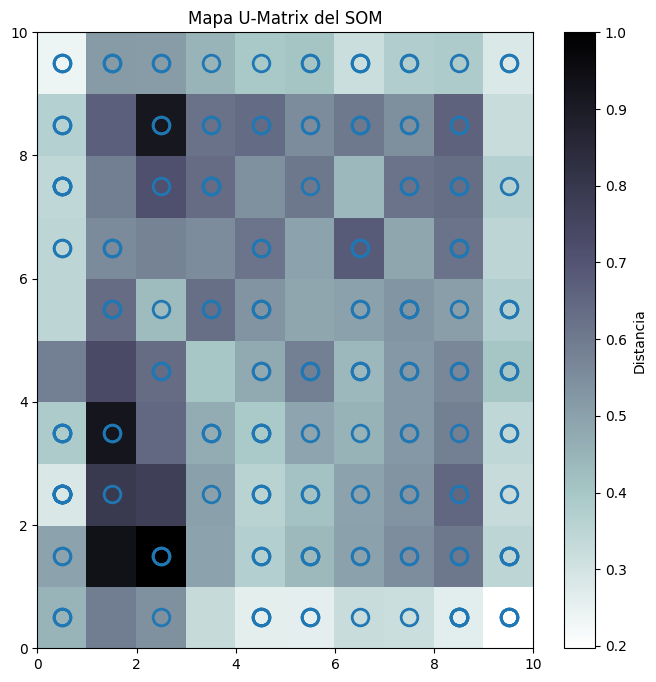

In [ ]:
#--------- entrenar y visualizar un SOM  ---------
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import pandas as pd

# Asumiendo que X_scaled es tu dataset escalado con variables numéricas relevantes

# Parámetros del SOM
map_width = 10  # ancho del mapa (puedes ajustar)
map_height = 10  # alto del mapa (puedes ajustar)
input_len = X_scaled.shape[1]  # número de variables

# Inicializar SOM
som = MiniSom(x=map_width, y=map_height, input_len=input_len, sigma=1.0, learning_rate=0.5, random_seed=42)

# Inicialización de pesos y entrenamiento
som.random_weights_init(X_scaled)
print("Entrenando SOM...")
som.train_random(data=X_scaled, num_iteration=1000)
print("Entrenamiento finalizado.")

# Visualización del mapa de distancia (U-Matrix)
plt.figure(figsize=(8, 8))
plt.title("Mapa U-Matrix del SOM")
plt.pcolor(som.distance_map().T, cmap='bone_r')  # mapa de distancias entre neuronas
plt.colorbar(label='Distancia')

# Opcional: añadir los puntos proyectados en el mapa para visualización
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # distintos marcadores para clusters si los tienes
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Si tienes etiquetas o clusters, puedes asignar colores/marcadores
# Si no, simplemente marca todos los puntos igual

for i, x in enumerate(X_scaled):
    w = som.winner(x)  # neurona ganadora para el dato i
    plt.plot(w[0]+0.5, w[1]+0.5, markers[0], markerfacecolor='None', markeredgecolor=colors[0], markersize=12, markeredgewidth=2)

plt.show()


Resultados métricas para segmentación basada en SOM con k=3:
Silhouette Score: 0.281
Calinski-Harabasz Index: 79.386
Davies-Bouldin Index: 1.336


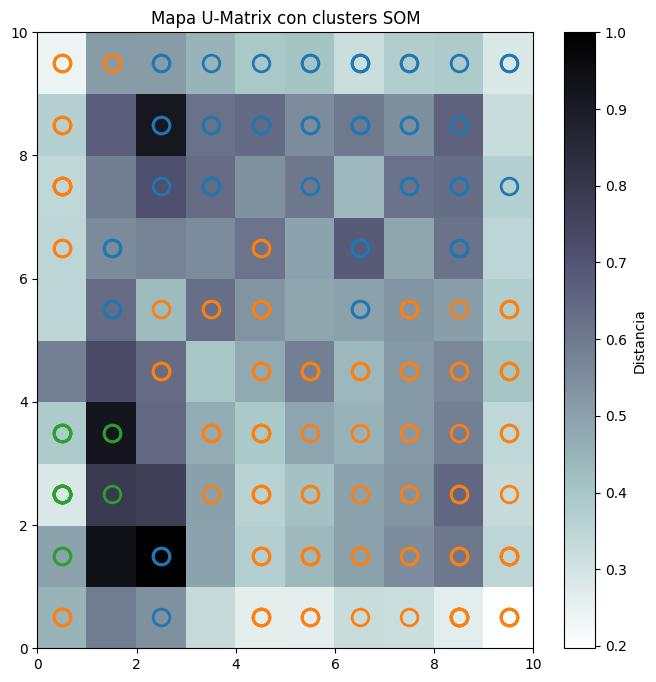

In [ ]:
#--------- MÉTRICAS PARA VALIDAR SOM ---------

# Parámetros SOM
map_width, map_height = 10, 10
input_len = X_scaled.shape[1]

# Crear y entrenar SOM
som = MiniSom(map_width, map_height, input_len, sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, 1000)

# Obtener pesos de las neuronas
weights = som.get_weights().reshape(map_width * map_height, input_len)

# Clusterizar neuronas con K-Means
k_clusters = 3  # Número de clusters deseados para segmentación
kmeans_som = KMeans(n_clusters=k_clusters, random_state=42)
kmeans_som.fit(weights)
neuron_cluster_labels = kmeans_som.labels_

# Asignar a cada dato el cluster de su neurona ganadora
win_map = np.array([som.winner(x) for x in X_scaled])
win_map_indices = win_map[:,0] * map_height + win_map[:,1]
data_cluster_labels = neuron_cluster_labels[win_map_indices]

# Evaluar métricas clásicas para la segmentación SOM
sil = silhouette_score(X_scaled, data_cluster_labels)
ch = calinski_harabasz_score(X_scaled, data_cluster_labels)
db = davies_bouldin_score(X_scaled, data_cluster_labels)

print(f"Resultados métricas para segmentación basada en SOM con k={k_clusters}:")
print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski-Harabasz Index: {ch:.3f}")
print(f"Davies-Bouldin Index: {db:.3f}")

# Visualización U-Matrix + clusters
plt.figure(figsize=(8,8))
plt.title("Mapa U-Matrix con clusters SOM")

# Mapa de distancias
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar(label='Distancia')

# Colores para clusters
colors = ['C0', 'C1', 'C2', 'C3', 'C4'][:k_clusters]

# Marcar cada dato con color según cluster
for i, x in enumerate(X_scaled):
    w = som.winner(x)
    cluster_idx = neuron_cluster_labels[w[0]*map_height + w[1]]
    plt.plot(w[0]+0.5, w[1]+0.5, 'o', markerfacecolor='None',
             markeredgecolor=colors[cluster_idx], markersize=12, markeredgewidth=2)

plt.show()


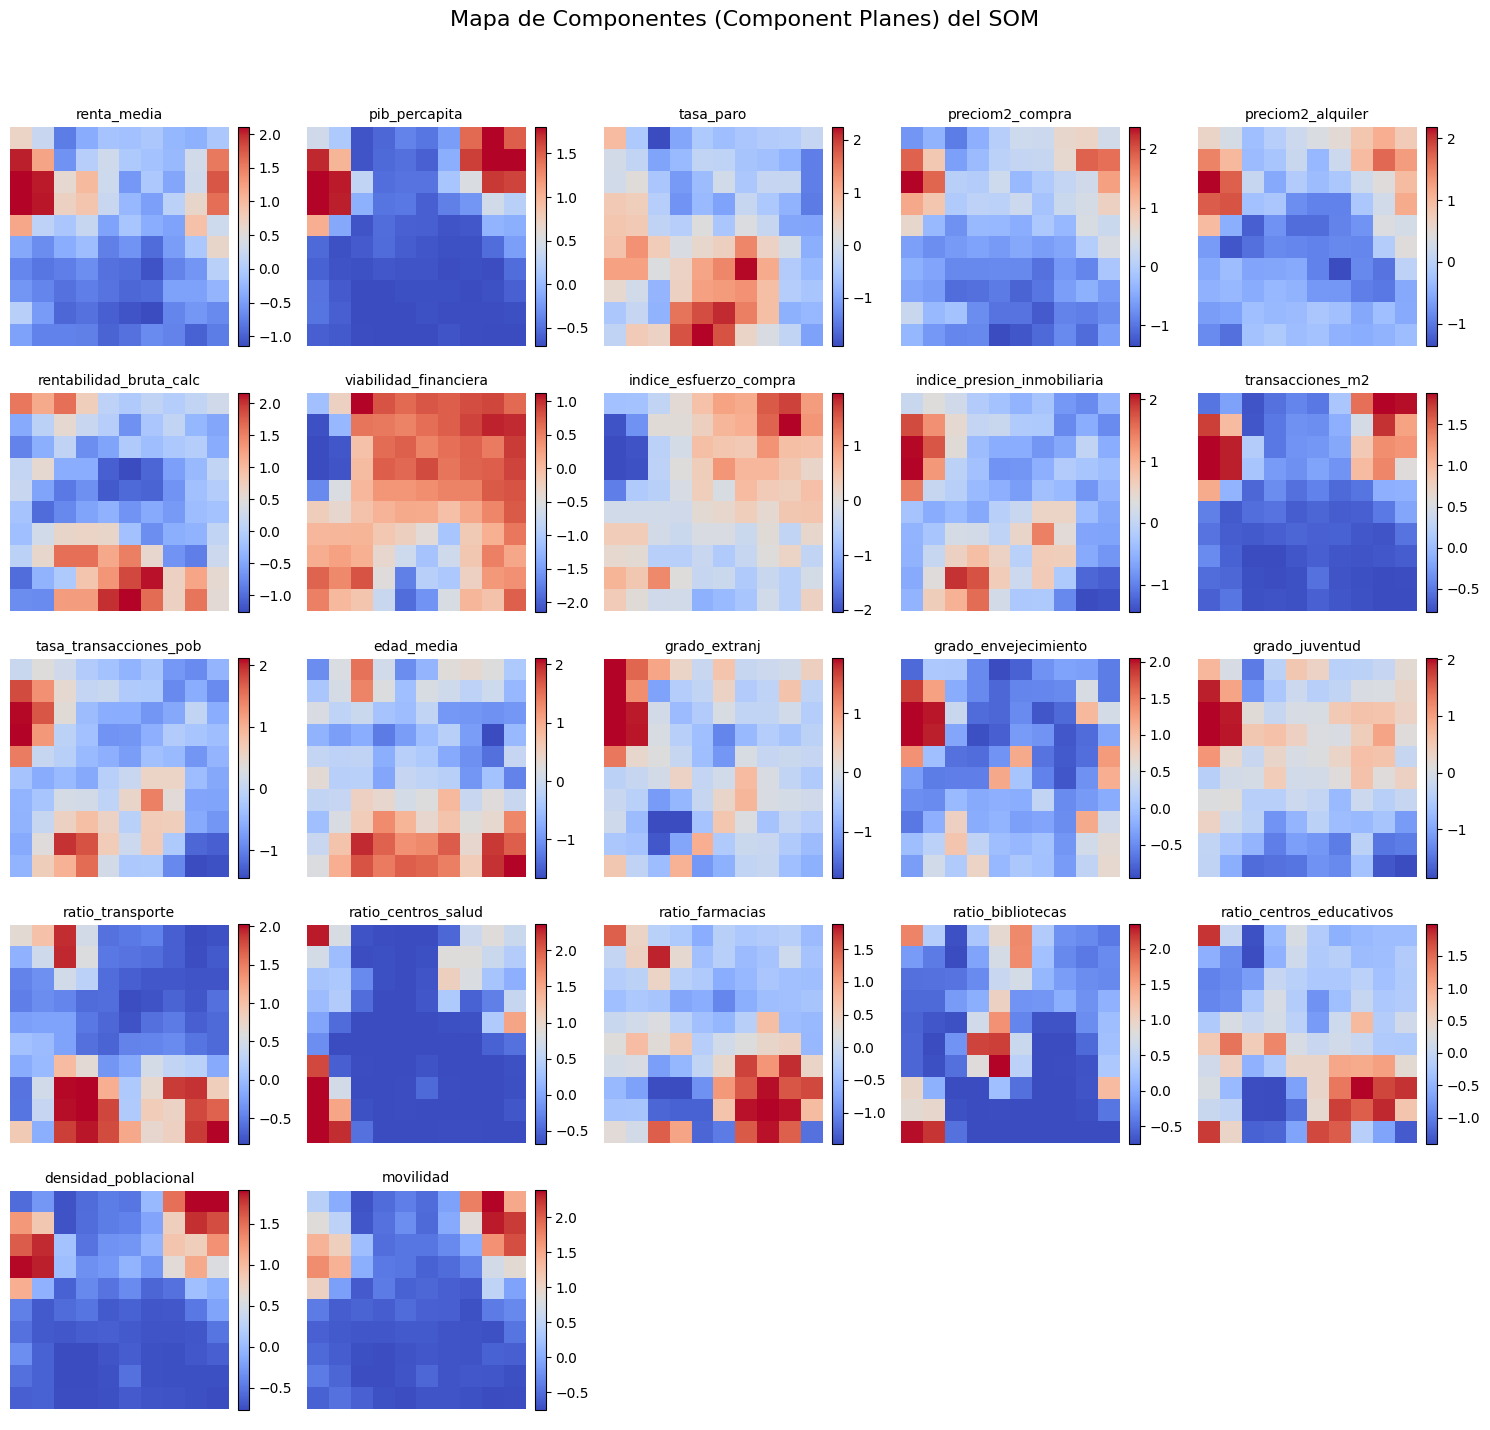

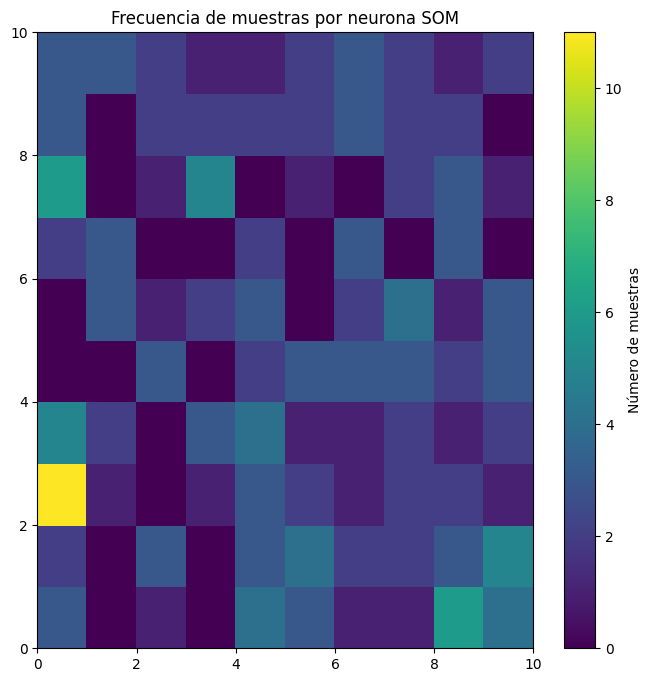

In [ ]:
# Mapa de Componentes para cada variable
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))  # Ajusta filas y columnas según variables
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < input_len:
        component = som.get_weights()[:, :, i]
        im = ax.imshow(component.T, cmap='coolwarm')
        ax.set_title(variables_finales[i], fontsize=10)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.axis('off')

plt.suptitle('Mapa de Componentes (Component Planes) del SOM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Mapa de frecuencia de datos por neurona
from collections import Counter

win_map = [som.winner(x) for x in X_scaled]
freq = Counter(win_map)

freq_map = np.zeros((map_width, map_height))
for (x,y), count in freq.items():
    freq_map[x,y] = count

plt.figure(figsize=(8,8))
plt.title('Frecuencia de muestras por neurona SOM')
plt.pcolor(freq_map.T, cmap='viridis')
plt.colorbar(label='Número de muestras')
plt.show()


,renta_media,pib_percapita,tasa_paro,preciom2_compra,preciom2_alquiler,rentabilidad_bruta_calc,viabilidad_financiera,indice_esfuerzo_compra,indice_presion_inmobiliaria,transacciones_m2,tasa_transacciones_pob,edad_media,grado_extranj,grado_envejecimiento,grado_juventud,ratio_transporte,ratio_centros_salud,ratio_farmacias,ratio_bibliotecas,ratio_centros_educativos,densidad_poblacional,movilidad
cluster_som,,,,,,,,,,,,,,,,,,,,,,
0,-0.432296,-0.117173,0.548485,-0.613075,-0.244121,0.781448,-0.569541,-0.341120,0.381645,-0.184197,0.381645,0.964163,-0.173026,0.413505,-0.874520,1.523174,0.000000,0.896198,-0.181803,0.407903,-0.194820,-0.130256
1,0.296805,0.611084,-0.138899,0.177748,0.156409,-0.116217,0.124683,0.339784,-0.150254,0.546458,-0.150254,-0.291260,0.086542,0.074374,0.167645,-0.049722,0.789474,0.072416,0.696163,0.239530,0.535481,0.492036
2,2.124666,2.391577,0.266037,1.591821,1.793733,-0.158116,-2.172192,-1.921454,1.958820,2.332438,1.958820,-0.178915,2.151752,2.262601,2.028614,0.057511,0.860913,0.025822,-0.011392,-0.657272,2.211434,1.511502


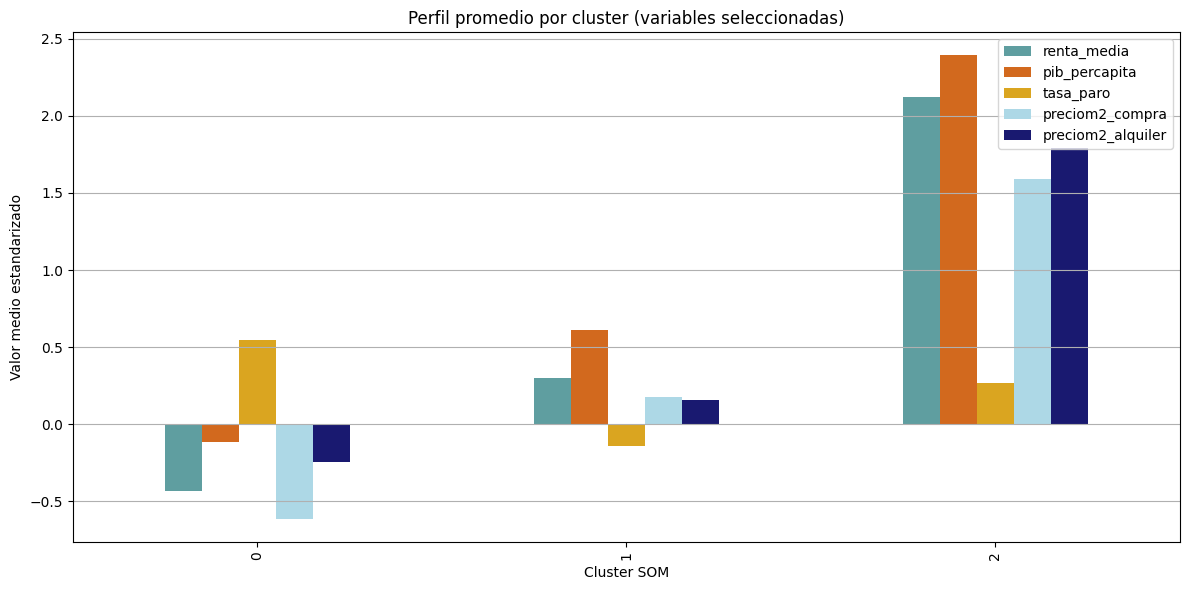

In [ ]:
import matplotlib.pyplot as plt

# Convertir etiquetas SOM a columna en dataframe original
df_som = df.copy()
df_som['cluster_som'] = data_cluster_labels

# Calcular media por cluster
perfil_clusters = df_som.groupby('cluster_som')[variables_finales].mean()

# Mostrar tabla
display(perfil_clusters.style.background_gradient(cmap='Blues'))



# Paleta de colores personalizada para las variables
colores_personalizados = ['#5F9EA0', '#D2691E', '#DAA520', '#ADD8E6', '#191970']  # Azul, naranja, verde, rojo, morado

# Graficar perfil promedio por cluster con colores personalizados
perfil_clusters[variables_finales[:5]].plot(kind='bar', figsize=(12,6), color=colores_personalizados)

plt.title('Perfil promedio por cluster (variables seleccionadas)')
plt.ylabel('Valor medio estandarizado')
plt.xlabel('Cluster SOM')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



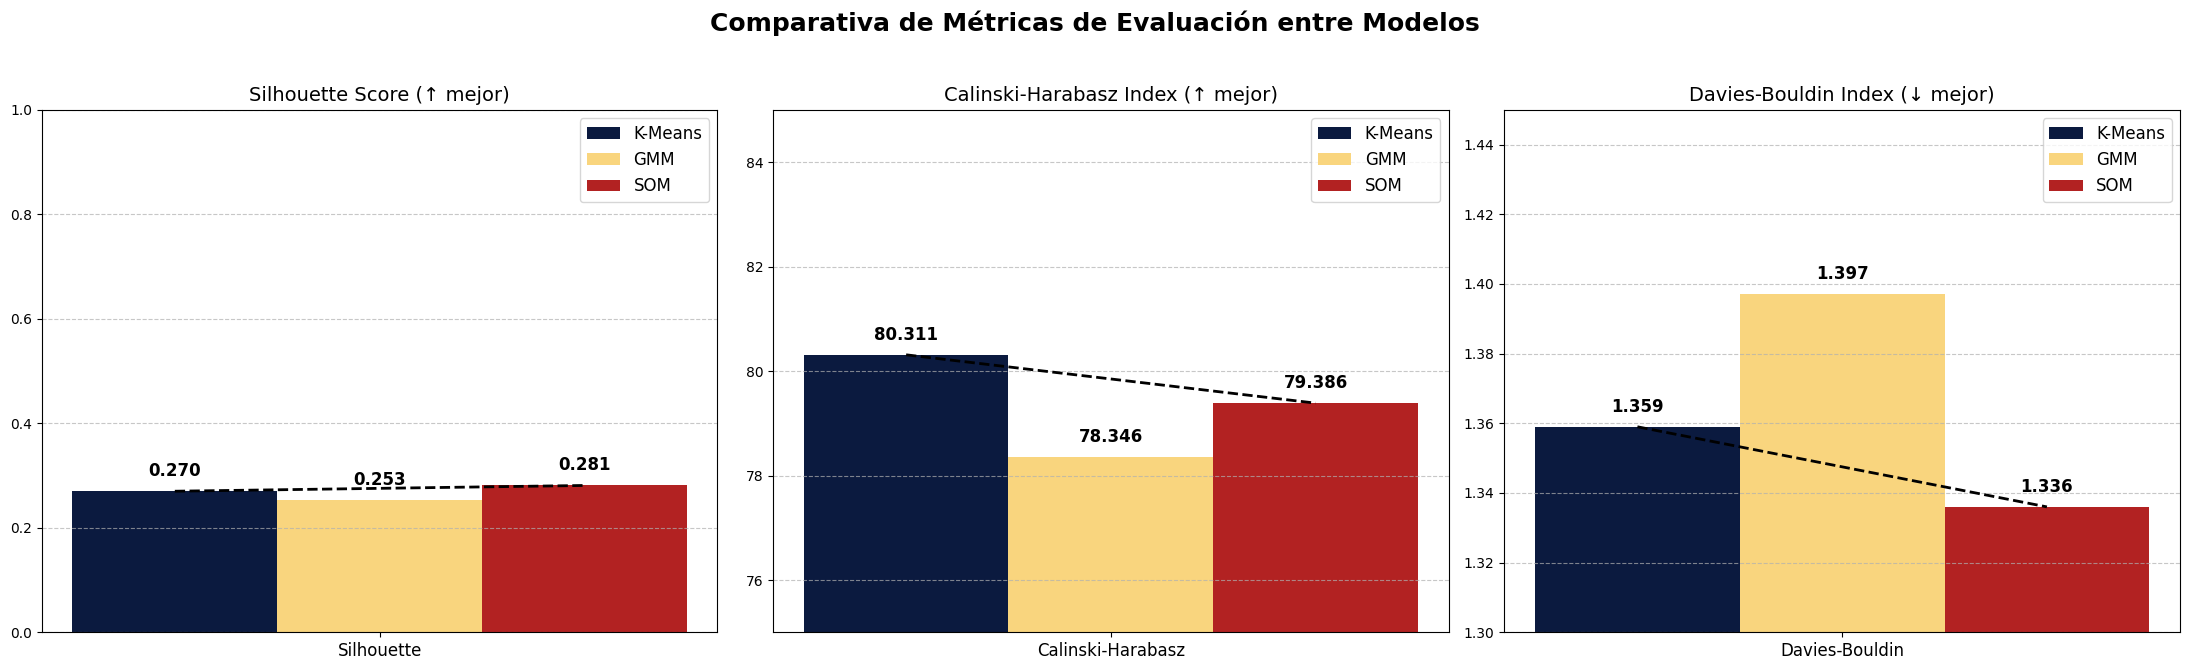

In [ ]:
# --------- histograma Métricas de Evaluación K-means vs GMM ---------

# Métricas y valores actualizados con SOM
metricas = ['Silhouette Score', 'Calinski-Harabasz', 'Davies-Bouldin']
valores_kmeans = [0.270, 80.311, 1.359]
valores_gmm = [0.253, 78.346, 1.397]
valores_som = [0.281, 79.386, 1.336]

x = np.arange(len(metricas))  # posiciones para cada métrica
width = 0.2  # ancho de las barras

fig, axs = plt.subplots(1, 3, figsize=(22, 7))

def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

# Silhouette Score (mayor es mejor)
rects1 = axs[0].bar(x[0] - width, valores_kmeans[0], width, label='K-Means', color='#0B1A3F')
rects2 = axs[0].bar(x[0], valores_gmm[0], width, label='GMM', color='#F9D57E')
rects3 = axs[0].bar(x[0] + width, valores_som[0], width, label='SOM', color='#B22222')  # rojo cereza
axs[0].set_title('Silhouette Score (↑ mejor)', fontsize=14)
axs[0].set_xticks([x[0]])
axs[0].set_xticklabels(['Silhouette'], fontsize=12)
axs[0].set_ylim(0, 1)
axs[0].plot([x[0] - width, x[0] + width], [valores_kmeans[0], valores_som[0]], color='black', linestyle='--', linewidth=2)
autolabel(axs[0], rects1)
autolabel(axs[0], rects2)
autolabel(axs[0], rects3)

# Calinski-Harabasz (mayor es mejor)
rects1 = axs[1].bar(x[1] - width, valores_kmeans[1], width, label='K-Means', color='#0B1A3F')
rects2 = axs[1].bar(x[1], valores_gmm[1], width, label='GMM', color='#F9D57E')
rects3 = axs[1].bar(x[1] + width, valores_som[1], width, label='SOM', color='#B22222')  # rojo cereza
axs[1].set_title('Calinski-Harabasz Index (↑ mejor)', fontsize=14)
axs[1].set_xticks([x[1]])
axs[1].set_xticklabels(['Calinski-Harabasz'], fontsize=12)
axs[1].set_ylim(75, 85)
axs[1].plot([x[1] - width, x[1] + width], [valores_kmeans[1], valores_som[1]], color='black', linestyle='--', linewidth=2)
autolabel(axs[1], rects1)
autolabel(axs[1], rects2)
autolabel(axs[1], rects3)

# Davies-Bouldin (menor es mejor)
rects1 = axs[2].bar(x[2] - width, valores_kmeans[2], width, label='K-Means', color='#0B1A3F')
rects2 = axs[2].bar(x[2], valores_gmm[2], width, label='GMM', color='#F9D57E')
rects3 = axs[2].bar(x[2] + width, valores_som[2], width, label='SOM', color='#B22222')  # rojo cereza
axs[2].set_title('Davies-Bouldin Index (↓ mejor)', fontsize=14)
axs[2].set_xticks([x[2]])
axs[2].set_xticklabels(['Davies-Bouldin'], fontsize=12)
axs[2].set_ylim(1.3, 1.45)
axs[2].plot([x[2] - width, x[2] + width], [valores_kmeans[2], valores_som[2]], color='black', linestyle='--', linewidth=2)
autolabel(axs[2], rects1)
autolabel(axs[2], rects2)
autolabel(axs[2], rects3)

for ax in axs:
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Comparativa de Métricas de Evaluación entre Modelos', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### **B4. MODELO DE SCORING INMOBILIARIO**

   k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  2    0.694324         668.561590        0.444825
1  3    0.607253         835.460927        0.489768
2  4    0.593179        1098.667580        0.471989
3  5    0.576179        1439.672855        0.481510
4  6    0.577787        1508.385077        0.459173


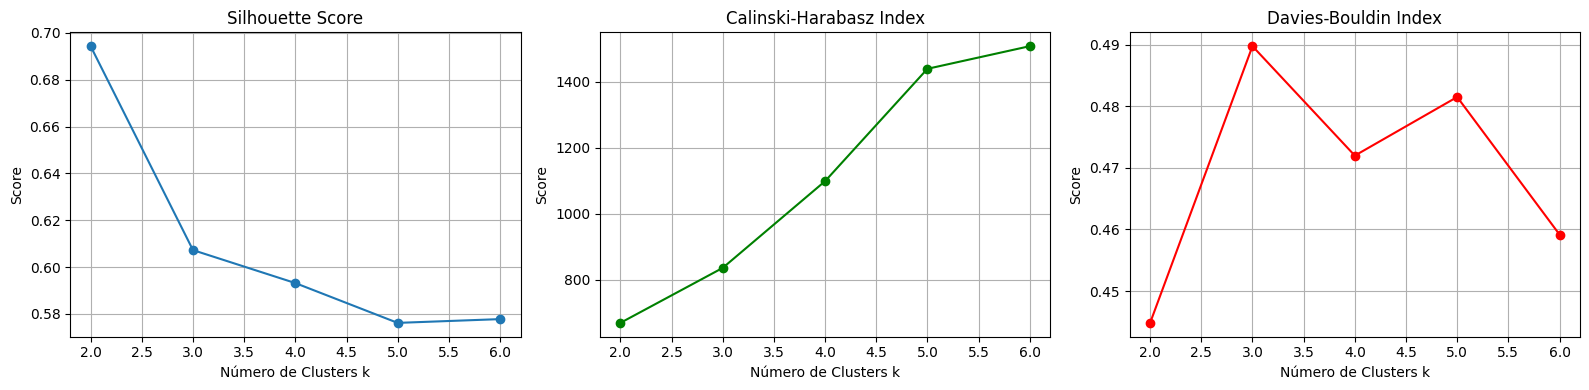

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar base datos
df = pd.read_excel('/content/BBDD_E1_listo.xlsx')

# Selección variables para scoring (ajustar según disponibilidad)
variables_scoring = [
    'renta_media', 'pib_percapita', 'tasa_paro',
    'preciom2_compra', 'preciom2_alquiler'
]

# Eliminar filas con datos nulos en variables seleccionadas
df = df.dropna(subset=variables_scoring)

# Normalizar variables entre 0 y 1
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[variables_scoring] = scaler.fit_transform(df[variables_scoring])

# Crear scoring ponderado (ajustar pesos según criterio)
pesos = {
    'renta_media': 0.25,
    'pib_percapita': 0.25,
    'tasa_paro': -0.20,          # negativo: paro alto resta atractivo
    'preciom2_compra': 0.15,
    'preciom2_alquiler': 0.15
}

df_scaled['score'] = 0
for var, peso in pesos.items():
    df_scaled['score'] += df_scaled[var] * peso

# Análisis para determinar número óptimo de clusters en el scoring
rango_k = range(2, 7)  # puedes ampliar el rango

sil_scores = []
ch_scores = []
db_scores = []

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled[['score']])
    sil_scores.append(silhouette_score(df_scaled[['score']], labels))
    ch_scores.append(calinski_harabasz_score(df_scaled[['score']], labels))
    db_scores.append(davies_bouldin_score(df_scaled[['score']], labels))

# Mostrar resultados
results_df = pd.DataFrame({
    'k': list(rango_k),
    'Silhouette': sil_scores,
    'Calinski-Harabasz': ch_scores,
    'Davies-Bouldin': db_scores
})

print(results_df)

# Graficar las métricas para decidir k
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.plot(rango_k, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters k')
plt.ylabel('Score')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(rango_k, ch_scores, marker='o', color='green')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Número de Clusters k')
plt.ylabel('Score')
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(rango_k, db_scores, marker='o', color='red')
plt.title('Davies-Bouldin Index')
plt.xlabel('Número de Clusters k')
plt.ylabel('Score')
plt.grid(True)

plt.tight_layout()
plt.show()


segmento
Alto     108
Bajo      55
Medio     37
Name: count, dtype: int64


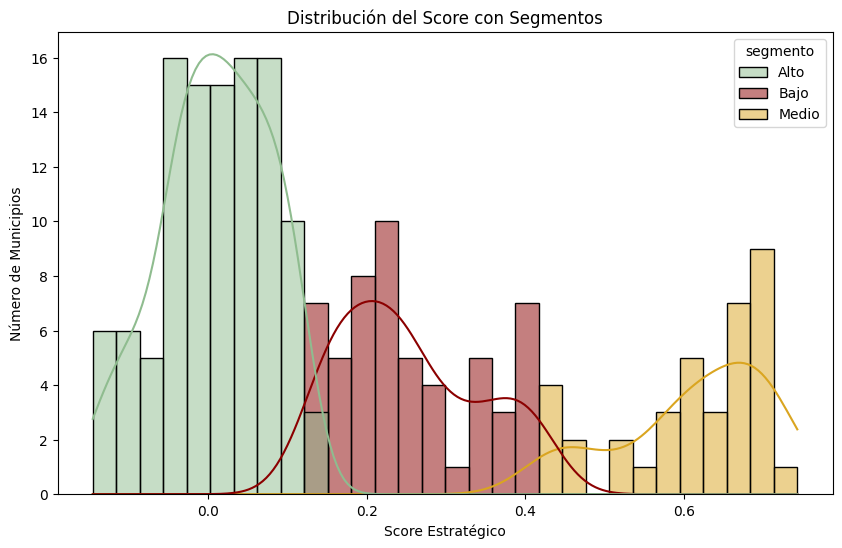

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir paleta personalizada 3 tonos azules (claro, medio, oscuro)
paleta_azules = ['#8FBC8F', '#8B0000', '#DAA520']

k_optimo = 3  # cambiar según resultados análisis anterior

kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
df_scaled['segmento'] = kmeans_final.fit_predict(df_scaled[['score']])

# Mapear etiquetas numéricas a categorías
segment_labels = {0: 'Bajo', 1: 'Medio', 2: 'Alto'}
df_scaled['segmento'] = df_scaled['segmento'].map(segment_labels)

# Mostrar distribución por segmento
print(df_scaled['segmento'].value_counts())

# Visualización con paleta personalizada
plt.figure(figsize=(10,6))
sns.histplot(data=df_scaled, x='score', hue='segmento', bins=30, kde=True, palette=paleta_azules)
plt.title('Distribución del Score con Segmentos')
plt.xlabel('Score Estratégico')
plt.ylabel('Número de Municipios')
plt.show()



In [ ]:
from sklearn.cluster import KMeans

# Supongamos que tu dataframe con scores se llama df_scaled y contiene la columna 'score'

k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)

# Clustering sobre la columna 'score' (debe ser un DataFrame 2D)
df_scaled['segmento'] = kmeans.fit_predict(df_scaled[['score']])

# Mapear etiquetas numéricas a categorías
segment_labels = {0: 'Bajo', 1: 'Medio', 2: 'Alto'}
df_scaled['segmento'] = df_scaled['segmento'].map(segment_labels)


In [ ]:
for segmento in ['Alto', 'Medio', 'Bajo']:
    print(f"\nMunicipios en segmento '{segmento}':")
    municipios = df_scaled[df_scaled['segmento'] == segmento].sort_values(by='score', ascending=False)['municipio_cm'].tolist()
    print(municipios)



Municipios en segmento 'Alto':
['Molinos', 'Becerril de la Sierra', 'Cercedilla', 'Serranillos del Valle', 'Molar', 'Torrejón de Velasco', 'Quijorna', 'Miraflores de la Sierra', 'Cabanillas de la Sierra', 'Torres de la Alameda', 'Valdetorres de Jarama', 'Horcajuelo de la Sierra', 'Rascafría', 'Berzosa del Lozoya', 'Patones', 'Campo Real', 'Braojos', 'Acebeda', 'Pinilla del Valle', 'Batres', 'San Martín de la Vega', 'Guadalix de la Sierra', 'Casarrubuelos', 'Torremocha de Jarama', 'Alamo', 'Madarcos', 'Cabrera ', 'Torrelaguna', 'Montejo de la Sierra', 'Nuevo Baztán', 'Gascones', 'Buitrago del Lozoya', 'Puentes Viejas', 'Puebla de la Sierra', 'Fresno de Torote', 'Colmenar del Arroyo', 'Morata de Tajuña', 'Santos de la Humosa ', 'Colmenar de Oreja', 'Lozoya', 'Santorcaz', 'Valdemanco', 'Anchuelo', 'Villar del Olmo', 'Bustarviejo', 'Berrueco', 'Serna del Monte', 'Vellón ', 'Redueña', 'Garganta de los Montes', 'Lozoyuela-Navas-Sieteiglesias', 'San Martín de Valdeiglesias', 'Piñuecar-Gandul

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Carga el shapefile de municipios de Madrid
gdf_madrid = gpd.read_file('/content/recintos_municipales_inspire_peninbal_etrs89.shp')

# Función para limpiar nombres y facilitar matching
def limpiar_nombre(nombre):
    if isinstance(nombre, str):
        nombre = nombre.lower().strip()
        nombre = nombre.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')
        nombre = nombre.replace('ñ','n')
        return nombre
    else:
        return nombre

# Aplicar limpieza de nombres al GeoDataFrame
gdf_madrid['nombre_limpio'] = gdf_madrid['NOMBRE'].apply(limpiar_nombre)

# Listas limpias para segmentación (minúsculas, sin tildes ni espacios al inicio/final)
municipios_alto = [m.lower().strip().replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u').replace('ñ','n') for m in [
    'Molinos', 'Becerril de la Sierra', 'Cercedilla', 'Serranillos del Valle', 'Molar', 'Torrejón de Velasco', 'Quijorna', 'Miraflores de la Sierra',
    'Cabanillas de la Sierra', 'Torres de la Alameda', 'Valdetorres de Jarama', 'Horcajuelo de la Sierra', 'Rascafría', 'Berzosa del Lozoya', 'Patones',
    'Campo Real', 'Braojos', 'Acebeda', 'Pinilla del Valle', 'Batres', 'San Martín de la Vega', 'Guadalix de la Sierra', 'Casarrubuelos', 'Torremocha de Jarama',
    'Alamo', 'Madarcos', 'Cabrera ', 'Torrelaguna', 'Montejo de la Sierra', 'Nuevo Baztán', 'Gascones', 'Buitrago del Lozoya', 'Puentes Viejas',
    'Puebla de la Sierra', 'Fresno de Torote', 'Colmenar del Arroyo', 'Morata de Tajuña', 'Santos de la Humosa ', 'Colmenar de Oreja', 'Lozoya',
    'Santorcaz', 'Valdemanco', 'Anchuelo', 'Villar del Olmo', 'Bustarviejo', 'Berrueco', 'Serna del Monte', 'Vellón ', 'Redueña', 'Garganta de los Montes',
    'Lozoyuela-Navas-Sieteiglesias', 'San Martín de Valdeiglesias', 'Piñuecar-Gandullas', 'Pozuelo del Rey', 'Villavieja del Lozoya', 'Valdilecha',
    'Robledo de Chavela', 'Villa del Prado', 'Navalagamella', 'Valdeavero', 'Villamantilla', 'Gargantilla del Lozoya y Pinilla de Buitrago', 'Corpa',
    'Valdepiélagos', 'Chapinería', 'Aldea del Fresno', 'Pezuela de las Torres', 'Valverde de Alcalá', 'Olmeda de las Fuentes', 'Navas del Rey', 'Somosierra',
    'Villamanta', 'Prádena del Rincón', 'Villarejo de Salvanés', 'Perales de Tajuña', 'Navalafuente', 'Belmonte de Tajo', 'Canencia', 'Rozas de Puerto Real',
    'Tielmes', 'Navarredonda y San Mamés', 'Chinchón', 'Ribatejada', 'Carabaña', 'Cervera de Buitrago', 'Estremera', 'Horcajo de la Sierra-Aoslos',
    'Fresnedillas de la Oliva', 'Alameda del Valle', 'Titulcia', 'Robregordo', 'Villaconejos', 'Fuentidueña de Tajo', 'Valdelaguna', 'Santa María de la Alameda',
    'Brea de Tajo', 'Hiruela', 'Zarzalejo', 'Robledillo de la Jara', 'Cadalso de los Vidrios', 'Valdaracete', 'Cenicientos', 'Ambite', 'Atazar',
    'Pelayos de la Presa', 'Orusco de Tajuña', 'Valdemaqueda', 'Villamanrique de Tajo'
]]

municipios_medio = [m.lower().strip().replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u').replace('ñ','n') for m in [
    'Pozuelo de Alarcón', 'Chamartín', 'Salamanca', 'Moncloa-Aravaca', 'Majadahonda', 'Chamberí', 'Retiro', 'Arganzuela', 'Tetuán', 'Centro',
    'Rozas de Madrid ', 'Hortaleza', 'Fuencarral-El Pardo', 'Ciudad Lineal', 'Tres Cantos', 'Barajas', 'Boadilla del Monte', 'Moratalaz',
    'San Blas-Canillejas', 'Latina', 'Vicálvaro', 'Alcobendas', 'Villa de Vallecas', 'Usera', 'Carabanchel', 'Madrid', 'Villaverde',
    'Puente de Vallecas', 'San Sebastián de los Reyes', 'Villaviciosa de Odón', 'Rivas-Vaciamadrid', 'Torrelodones', 'Getafe', 'Alcorcón',
    'Pinto', 'Coslada', 'San Fernando de Henares'
]]

municipios_bajo = [m.lower().strip().replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u').replace('ñ','n') for m in [
    'Valdemoro', 'Torrejón de Ardoz', 'Móstoles', 'Alcalá de Henares', 'Leganés', 'Paracuellos de Jarama', 'Arganda del Rey', 'Fuenlabrada',
    'Aranjuez', 'Villanueva del Pardillo', 'Collado Villalba', 'Algete', 'Arroyomolinos', 'Villanueva de la Cañada', 'Parla', 'Colmenar Viejo',
    'San Agustín del Guadalix', 'Cobeña', 'Hoyo de Manzanares', 'Griñón', 'Galapagar', 'Ajalvir', 'Moralzarzal', 'Venturada', 'Daganzo de Arriba',
    'Valdeolmos-Alalpardo', 'Humanes de Madrid', 'Meco', 'Soto del Real', 'Brunete', 'San Lorenzo de El Escorial', 'Alpedrete', 'Villalbilla',
    'Escorial', 'Navalcarnero', 'Guadarrama', 'Ciempozuelos', 'Fuente el Saz de Jarama', 'Valdemorillo', 'Boalo', 'Loeches', 'Colmenarejo',
    'Velilla de San Antonio', 'Mejorada del Campo', 'Sevilla la Nueva', 'Moraleja de Enmedio', 'Navacerrada', 'Collado Mediano', 'Villanueva de Perales',
    'Camarma de Esteruelas', 'Pedrezuela', 'Torrejón de la Calzada', 'Manzanares el Real', 'Talamanca de Jarama', 'Cubas de la Sagra'
]]

# Función para asignar segmento según municipio
def asignar_segmento(municipio):
    if municipio in municipios_alto:
        return 'Alto'
    elif municipio in municipios_medio:
        return 'Medio'
    elif municipio in municipios_bajo:
        return 'Bajo'
    else:
        return 'No asignado'

# Aplicar asignación
gdf_madrid['segmento'] = gdf_madrid['nombre_limpio'].apply(asignar_segmento)

# Paleta colores personalizada
paleta_azules = {'Bajo': '#c6dbef', 'Medio': '#6baed6', 'Alto': '#08306b', 'No asignado': '#f0f0f0'}

# Añadir columna color
gdf_madrid['color'] = gdf_madrid['segmento'].map(paleta_azules)

# Graficar
fig, ax = plt.subplots(figsize=(12, 12))
gdf_madrid.plot(ax=ax, color=gdf_madrid['color'], edgecolor='black', linewidth=0.3)

ax.set_title('Segmentación Estratégica por Municipio - Comunidad de Madrid', fontsize=16)
ax.axis('off')

# Crear leyenda personalizada
leyenda = [mpatches.Patch(color=color, label=label) for label, color in paleta_azules.items() if label != 'No asignado']
ax.legend(handles=leyenda, title='Segmento de Inversión', loc='lower left')

plt.tight_layout()
plt.show()


KeyError: 'NOMBRE'

In [ ]:
print(gdf_madrid.head()[['NOMBRE']])  # o cambia 'NOMBRE' por el nombre correcto


KeyError: "None of [Index(['NOMBRE'], dtype='object')] are in the [columns]"

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Cargar shapefile si no está cargado ya
gdf_madrid = gpd.read_file('/content/recintos_municipales_inspire_peninbal_etrs89.shp')

# Limpieza de nombres para facilitar matching
def limpiar_nombre(nombre):
    if isinstance(nombre, str):
        nombre = nombre.lower().strip()
        nombre = nombre.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')
        nombre = nombre.replace('ñ','n')
        return nombre
    else:
        return nombre

gdf_madrid['nombre_limpio'] = gdf_madrid['NOMBRE'].apply(limpiar_nombre)

# Define listas limpias (aplica la misma limpieza a tus listas)
municipios_alto = ['molinos', 'becerril de la sierra', 'cercedilla', 'serranillos del valle', 'molar',
                  'torrejon de velasco', 'quijorna', 'miraflores de la sierra', 'cabanillas de la sierra',
                  # ... sigue con todas tus entradas convertidas a minusculas y sin tildes
                 ]

municipios_medio = ['pozuelo de alarcon', 'chamartin', 'salamanca', 'moncloa-aravaca', 'majadahonda',
                   # ...
                  ]

municipios_bajo = ['valdemoro', 'torrejon de ardoz', 'mostoles', 'alcala de henares', 'leganes',
                  # ...
                 ]

# Crear una función para asignar segmento según el municipio
def asignar_segmento(municipio):
    if municipio in municipios_alto:
        return 'Alto'
    elif municipio in municipios_medio:
        return 'Medio'
    elif municipio in municipios_bajo:
        return 'Bajo'
    else:
        return 'No asignado'

# Aplicar asignación
gdf_madrid['segmento'] = gdf_madrid['nombre_limpio'].apply(asignar_segmento)

# Paleta colores personalizada
paleta_azules = {'Bajo': '#c6dbef', 'Medio': '#6baed6', 'Alto': '#08306b', 'No asignado': '#f0f0f0'}

# Añadir columna color
gdf_madrid['color'] = gdf_madrid['segmento'].map(paleta_azules)

# Graficar
fig, ax = plt.subplots(figsize=(12, 12))
gdf_madrid.plot(ax=ax, color=gdf_madrid['color'], edgecolor='black', linewidth=0.3)

ax.set_title('Segmentación Estratégica por Municipio - Comunidad de Madrid', fontsize=16)
ax.axis('off')

# Crear leyenda personalizada
leyenda = [mpatches.Patch(color=color, label=label) for label, color in paleta_azules.items() if label != 'No asignado']
ax.legend(handles=leyenda, title='Segmento de Inversión', loc='lower left')

plt.tight_layout()
plt.show()


KeyError: 'NOMBRE'

In [ ]:
# Gráfico de barras con colores de semáforo
top_20 = df[['municipio_cm', 'score_inversion', 'clasificacion']].sort_values(by='score_inversion', ascending=False).head(20)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_20,
    x='score_inversion',
    y='municipio_cm',
    hue='clasificacion',
    dodge=False,
    palette={'🔴 Bajo': '#E74C3C', '🟡 Medio': '#F1C40F', '🟢 Alto': '#27AE60'}
)
plt.title("🔍 Municipios con mayor potencial de inversión inmobiliaria", fontweight='bold')
plt.xlabel("Índice Estratégico de Inversión", fontweight='bold')
plt.ylabel("Municipio", fontweight='bold')
plt.legend(title='Clasificación tipo semáforo')
plt.tight_layout()
plt.show()


KeyError: "['score_inversion', 'clasificacion'] not in index"

### **CON EL MAPA**

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ruta al archivo .shp (asegúrate que el nombre coincide exactamente)
ruta = "/content/recintos_municipales_inspire_peninbal_etrs89.shp"

# Cargar shapefile completo
gdf = gpd.read_file(ruta)

# Visualiza las columnas disponibles (opcional para saber cómo filtrar)
print(gdf.columns)

# Ver algunas filas para identificar la columna del código de provincia
print(gdf.head())


Index(['INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE', 'NAMEUNIT',
       'CODNUT1', 'CODNUT2', 'CODNUT3', 'geometry'],
      dtype='object')
                  INSPIREID COUNTRY  \
0  ES.IGN.BDDAE.34040707901      ES   
1  ES.IGN.BDDAE.34040707902      ES   
2  ES.IGN.BDDAE.34164848057      ES   
3  ES.IGN.BDDAE.34164848058      ES   
4  ES.IGN.BDDAE.34164848059      ES   

                                              NATLEV NATLEVNAME      NATCODE  \
0  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34040707901   
1  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34040707902   
2  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34164848057   
3  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34164848058   
4  https://inspire.ec.europa.eu/codelist/Administ...  Municipio  34164848059   

          NAMEUNIT CODNUT1 CODNUT2 CODNUT3  \
0           Ariany     ES5    ES53   ES532   
1  Es Migjorn Gran     ES5    ES53   ES

In [ ]:
# Verifica valores únicos primero (opcional)
print(gdf['CODNUT3'].unique())

# Filtrar por CODNUT3 correspondiente a Madrid
gdf_madrid = gdf[gdf['CODNUT3'] == 'ES300']

# Confirmamos
print(f"Total municipios seleccionados: {len(gdf_madrid)}")
gdf_madrid.head()

['ES532' 'ES533' 'ES213' 'ES220' 'ES211' 'ES230' 'ES113' 'ES130' 'ES114'
 'ES432' 'ES212' 'ES300' 'ES112' 'ES620' 'ES611' 'ES612' 'ES613' 'ES614'
 'ES615' 'ES616' 'ES617' 'ES618' 'ES241' 'ES242' 'ES243' 'ES120' 'ES531'
 'ES431' 'ES411' 'ES412' 'ES413' 'ES414' 'ES415' 'ES111' 'ES416' 'ES417'
 'ES418' 'ES419' 'ES421' 'ES422' 'ES630' 'ES640' None 'ES423' 'ES424'
 'ES425' 'ES511' 'ES512' 'ES513' 'ES514' 'ES521' 'ES522' 'ES523']
Total municipios seleccionados: 181


,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
183,ES.IGN.BDDAE.34132828049,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828049,Coslada,ES3,ES30,ES300,"POLYGON ((-3.53119 40.42008, -3.53023 40.41471..."
184,ES.IGN.BDDAE.34132828050,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828050,Cubas de la Sagra,ES3,ES30,ES300,"POLYGON ((-3.87632 40.19122, -3.87623 40.19123..."
185,ES.IGN.BDDAE.34132828051,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828051,Chapinería,ES3,ES30,ES300,"POLYGON ((-4.23555 40.39329, -4.23396 40.39376..."
186,ES.IGN.BDDAE.34132828052,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828052,Chinchón,ES3,ES30,ES300,"POLYGON ((-3.58093 40.09899, -3.58075 40.10069..."
187,ES.IGN.BDDAE.34132828053,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828053,Daganzo de Arriba,ES3,ES30,ES300,"POLYGON ((-3.48098 40.56217, -3.48022 40.56407..."


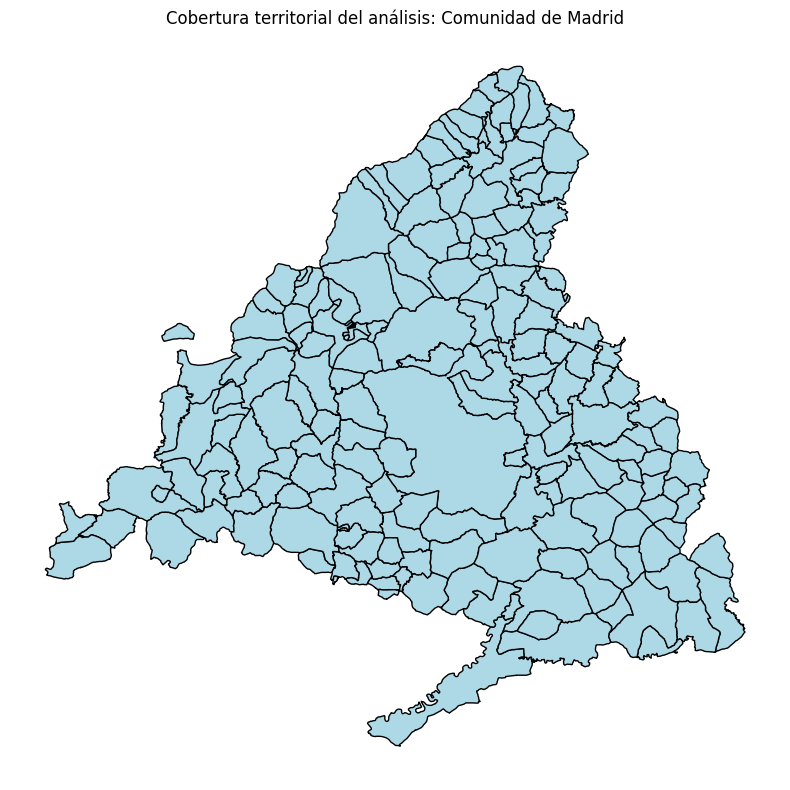

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
gdf_madrid.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title('Cobertura territorial del análisis: Comunidad de Madrid', fontsize=12)
ax.set_aspect('auto')  # evita errores de aspecto
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def limpiar_nombre(nombre):
    if isinstance(nombre, str):
        nombre = nombre.lower().strip()
        nombre = nombre.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')
        nombre = nombre.replace('ñ','n')
        return nombre
    else:
        return nombre

df_scaled['municipio_limpio'] = df_scaled['municipio_cm'].apply(limpiar_nombre)
gdf_madrid['nombre_limpio'] = gdf_madrid['NOMBRE'].apply(limpiar_nombre)


KeyError: 'NOMBRE'

In [ ]:
from sklearn.cluster import KMeans

k_optimo = 3  # o el valor que hayas decidido
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42)
df_scaled['segmento'] = kmeans_final.fit_predict(df_scaled[['score']])

# Mapear números a etiquetas
segment_labels = {0: 'Bajo', 1: 'Medio', 2: 'Alto'}
df_scaled['segmento'] = df_scaled['segmento'].map(segment_labels)


In [ ]:
# Revisar nombres de columnas para confirmar las usadas en el merge
print(df_scaled.columns)
print(df_scaled[['municipio_cm', 'segmento']].head())

print("Columnas GeoDataFrame:", gdf_madrid.columns)
print("Columnas DataFrame:", df_scaled.columns)

# Limpiar y homogeneizar nombres en GeoDataFrame y DataFrame para evitar fallos en el merge
def limpiar_nombre(nombre):
    if isinstance(nombre, str):
        nombre = nombre.lower().strip()           # minusculas y quitar espacios
        nombre = nombre.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')  # quitar tildes
        nombre = nombre.replace('ñ', 'n')          # reemplazar ñ por n si quieres (opcional)
        return nombre
    else:
        return nombre

gdf_madrid['nombre_limpio'] = gdf_madrid['NOMBRE'].apply(limpiar_nombre)
df_scaled['municipio_limpio'] = df_scaled['municipio_cm'].apply(limpiar_nombre)

# Ahora hacemos el merge con las columnas limpias
gdf_madrid = gdf_madrid.merge(df_scaled[['municipio_limpio', 'segmento']], left_on='nombre_limpio', right_on='municipio_limpio', how='left')

# Verificar que el merge se ha realizado bien
print(gdf_madrid[['NOMBRE', 'segmento']].head())

# Definir paleta de colores tonos azul
paleta_azules = {'Bajo': '#c6dbef', 'Medio': '#6baed6', 'Alto': '#08306b'}
gdf_madrid['color'] = gdf_madrid['segmento'].map(paleta_azules)

# Graficar el mapa con colores por segmento
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 8))
gdf_madrid.plot(ax=ax, color=gdf_madrid['color'], edgecolor='black')

ax.set_title('Segmentación Estratégica de la Comunidad de Madrid', fontsize=12)
ax.set_aspect('auto')
ax.axis('off')

leyenda = [mpatches.Patch(color=color, label=label) for label, color in paleta_azules.items()]
ax.legend(handles=leyenda, title='Segmento de Inversión', loc='lower left')

plt.tight_layout()
plt.show()


Index(['renta_media', 'pib_percapita', 'tasa_paro', 'preciom2_compra',
       'preciom2_alquiler', 'rentabilidad_bruta_calc', 'viabilidad_financiera',
       'indice_esfuerzo_compra', 'indice_presion_inmobiliaria',
       'transacciones_m2', 'tasa_transacciones_pob', 'edad_media',
       'grado_extranj', 'grado_envejecimiento', 'grado_juventud',
       'ratio_transporte', 'ratio_centros_salud', 'ratio_farmacias',
       'ratio_bibliotecas', 'ratio_centros_educativos', 'densidad_poblacional',
       'movilidad', 'municipio_cm', 'distrito_cm', 'score', 'segmento'],
      dtype='object')
        municipio_cm segmento
0            Acebeda     Alto
1            Ajalvir     Bajo
2  Alameda del Valle     Alto
3              Alamo     Alto
4  Alcalá de Henares     Bajo
Columnas GeoDataFrame: Index(['INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE', 'NAMEUNIT',
       'CODNUT1', 'CODNUT2', 'CODNUT3', 'geometry'],
      dtype='object')
Columnas DataFrame: Index(['renta_media', 'pib_perca

KeyError: 'NOMBRE'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Asumiendo que ya hiciste merge para unir datos al GeoDataFrame
# Si no, haz merge antes (por ejemplo):
# gdf_madrid = gdf_madrid.merge(df_scaled[['municipio_cm', 'segmento']], left_on='NOMBRE', right_on='municipio_cm', how='left')

# Definir paleta personalizada de tonos azules para los segmentos
paleta_azules = {'Bajo': '#c6dbef', 'Medio': '#6baed6', 'Alto': '#08306b'}

# Crear columna de colores basada en segmento
gdf_madrid['color'] = gdf_madrid['segmento'].map(paleta_azules)

fig, ax = plt.subplots(figsize=(8, 8))
# Dibujar municipios con color según segmento
gdf_madrid.plot(ax=ax, color=gdf_madrid['color'], edgecolor='black')

ax.set_title('Segmentación Estratégica de la Comunidad de Madrid', fontsize=12)
ax.set_aspect('auto')
ax.axis('off')

# Crear leyenda manual
import matplotlib.patches as mpatches
leyenda = [mpatches.Patch(color=color, label=label) for label, color in paleta_azules.items()]
ax.legend(handles=leyenda, title='Segmento de Inversión', loc='lower left')

plt.tight_layout()
plt.show()


KeyError: 'segmento'